# Differential gene expression analysis - code example for edgeR (pseudobulk)

Using the merged data set.

## 1. Environment setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [24]:
%%R
library(edgeR)
library(stringr)
library(EnhancedVolcano)

## 2. Reading in the annData pseudobulk object

In [3]:
adata_pb = sc.read("/home/sch/schonner/MaPra/merged_data_for_diffEx_edgeR.h5ad")
adata_pb

AnnData object with n_obs × n_vars = 508 × 23767
    obs: 'dataset', 'batch', 'sample', 'condition', 'fibrotic/control', 'coarse_harmonized_anno', 'harmonized_anno', 'author_annotation_coarse', 'author_annotation', 'lib_size', 'log_lib_size'
    uns: 'author_annotation_coarse_colors', 'author_annotation_colors', 'batch_colors', 'coarse_harmonized_anno_colors', 'condition_colors', 'dataset_colors', 'fibrotic', 'harmonized_anno_colors', 'log1p', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

## 3. Preparing the data, constructing the design matrix and performing the DE testing

### Define a separate function to fit an edgeR GLM:
This function takes a SingleCellExperiment object as input, creates the design matrix and outputs the fitted GLM (generalized linear model). We also output the edgeR object of class DGEList to do some exploratory data analysis (EDA).

It is not possible to use *design <- model.matrix(~ 0 + group + batch)* because then the Error "R error message: 'Error in glmFit.default(y, design = design, dispersion = dispersion, offset = offset,  : \n  Design matrix not of full rank." appears later on.

In [4]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$condition)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)   # keeps genes that have at least min.count (default: 10) reads in a worthwhile number samples
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create factors for the design matrix
    condition <- colData(adata_)$condition   # saline, asbestos, ...
    project <- colData(adata_)$dataset       # schiller, misharin, peyser, ...
    design <- model.matrix(~ 0 + condition + project)
    print(colnames(design))
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [5]:
adata_pb.obs["coarse_harmonized_anno"].cat.categories

Index(['Aerocytes', 'Alveolar_macrophages', 'B_cells', 'Classical_monocytes',
       'Dendritic_cells', 'Endothelial', 'Epithelial', 'Fibroblasts',
       'Interstitial_macrophages', 'Myofibroblasts', 'NA', 'NK_cells',
       'Neutrophils', 'Non_classical_monocytes', 'SMCs', 'T_cells'],
      dtype='object')

### 3.1 Testing with one cell group - Neutrophils

In [7]:
adata_Neutrophils = adata_pb[adata_pb.obs["coarse_harmonized_anno"] == "Neutrophils"]
adata_Neutrophils

View of AnnData object with n_obs × n_vars = 41 × 23767
    obs: 'dataset', 'batch', 'sample', 'condition', 'fibrotic/control', 'coarse_harmonized_anno', 'harmonized_anno', 'author_annotation_coarse', 'author_annotation', 'lib_size', 'log_lib_size'
    uns: 'author_annotation_coarse_colors', 'author_annotation_colors', 'batch_colors', 'coarse_harmonized_anno_colors', 'condition_colors', 'dataset_colors', 'fibrotic', 'harmonized_anno_colors', 'log1p', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [8]:
# clean the sample names to make plots less crowded
adata_Neutrophils.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_Neutrophils.obs_names
]

In [9]:
%%time
%%R -i adata_Neutrophils
outs_Neutrophils <- fit_model(adata_Neutrophils)

[1] "Dimensions before subsetting:"
[1] 23767    41
[1] ""
[1] "Dimensions after subsetting:"
[1] 919  41
[1] ""
[1] "conditionasbestos"  "conditionbleomycin" "conditionsaline"   
[4] "conditionuntreated" "projectpeyser"      "projectschiller"   
[7] "projecttsukui"      "projectxie"        
CPU times: user 7.85 s, sys: 581 ms, total: 8.43 s
Wall time: 10.2 s


In [10]:
%%R
fit_Neutrophils <- outs_Neutrophils$fit
y_Neutrophils <- outs_Neutrophils$y

#### 3.1.1 MDS plot:
Since we did not enter our analysis with a prior assumption that a specific gene will be up- or downregulated, we need visualizations to make sense of the DGE results. A MDS plot allows for a high level overview.

Commonly, we expect a separation between samples from different conditions. This can be seen for 'saline', 'untreated' clusters in the upper half of the plot. There is only one sample for 'asbestos' and 'bleomycin' is distributed over the whole plot.

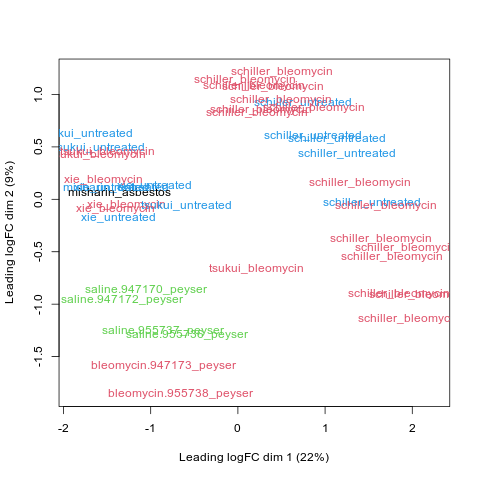

In [11]:
%%R
plotMDS(y_Neutrophils, labels = NULL, col = as.numeric(y_Neutrophils$samples$group))

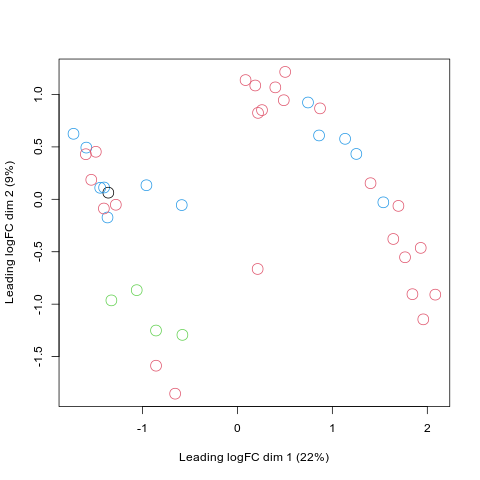

In [12]:
%%R
plotMDS(y_Neutrophils, labels = NULL, col = as.numeric(y_Neutrophils$samples$group), 
        pch = as.numeric(y_Neutrophils$samples$cell), cex = 2)

#### 3.1.2 Biological Coefficient of Variation (BCV) plot:

Shows the variability of every gene on average across biological groups as a function of mean expression. For example, bcv of 0.3 indicates that there is on average 30% percent variability in the expression of genes across groups.

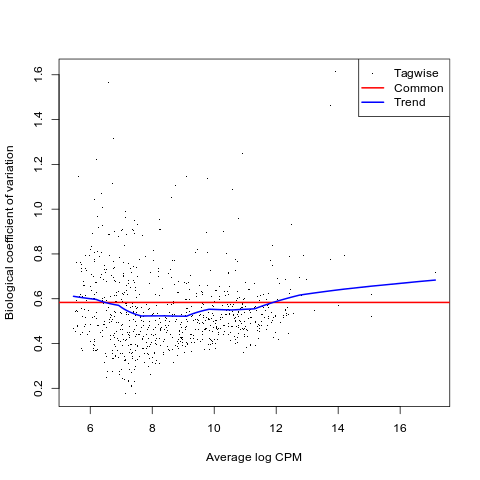

In [13]:
%%R
plotBCV(y_Neutrophils)

#### 3.1.3 Quasi-likelihood test to find DE genes between control and stimulated conditions:

In [14]:
%%R
colnames(y_Neutrophils$design)

[1] "conditionasbestos"  "conditionbleomycin" "conditionsaline"   
[4] "conditionuntreated" "projectpeyser"      "projectschiller"   
[7] "projecttsukui"      "projectxie"        


In [15]:
%%R -o tt_Neutrophils
myContrast_Neutrophils <- makeContrasts('conditionasbestos-conditionbleomycin-conditionsaline-conditionuntreated',
                                        levels = y_Neutrophils$design)
qlf_Neutrophils <- glmQLFTest(fit_Neutrophils, contrast=myContrast_Neutrophils)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt_Neutrophils <- topTags(qlf_Neutrophils, n = Inf)
tt_Neutrophils <- tt_Neutrophils$table

In [16]:
tt_Neutrophils.shape

(919, 5)

In [17]:
tt_Neutrophils.sort_values('logFC', ascending=False)[:5]   # genes with the highest logFC

,logFC,logCPM,F,PValue,FDR
Igfbp5,42.753178,6.247031,6.520711e+01,1.980982e-11,6.734978e-09
Ccna2,41.962078,6.489656,1.767805e-07,9.997998e-01,1.000000e+00
Prc1,41.834313,5.855819,5.065299e+01,4.985413e-08,3.882707e-07
Nusap1,40.457817,6.476225,3.530406e+01,2.019230e-07,1.072643e-06
Rbm10,39.816560,5.750075,7.331301e+01,1.675229e-10,2.565892e-08


In [18]:
tt_Neutrophils.sort_values('logFC')[:5]   # genes with the lowest logFC

,logFC,logCPM,F,PValue,FDR
S100a8,0.319827,17.133690,0.006288,0.937005,1.000000
S100a9,1.916944,16.602811,0.222981,0.638134,0.961386
Retnlg,4.666652,14.219094,1.071016,0.304006,0.458755
Lcn2,5.128495,12.417741,0.001153,0.972998,1.000000
Malat1,7.057483,15.063097,2.873813,0.094136,0.142522


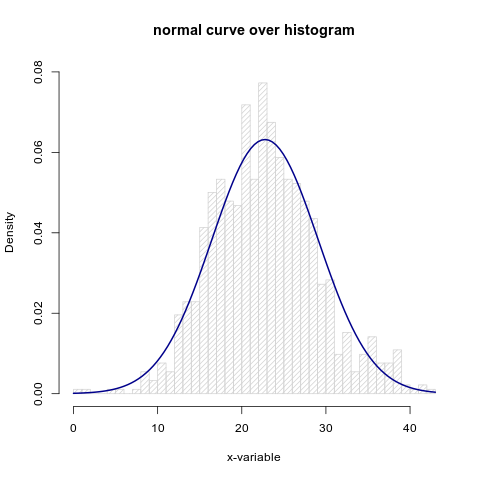

In [19]:
%%R

g = tt_Neutrophils$logFC
m<-mean(g)
std<-sqrt(var(g))
hist(g, density=20, breaks=50, prob=TRUE, 
     xlab="x-variable", ylim=c(0, 0.08), 
     main="normal curve over histogram")
curve(dnorm(x, mean=m, sd=std), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")

In [20]:
%%R
print(paste0("Mean: ", round(mean(tt_Neutrophils$logFC), 2)))
print(paste0("SD: ", round(sqrt(var(tt_Neutrophils$logFC)), 2)))

[1] "Mean: 22.76"
[1] "SD: 6.31"


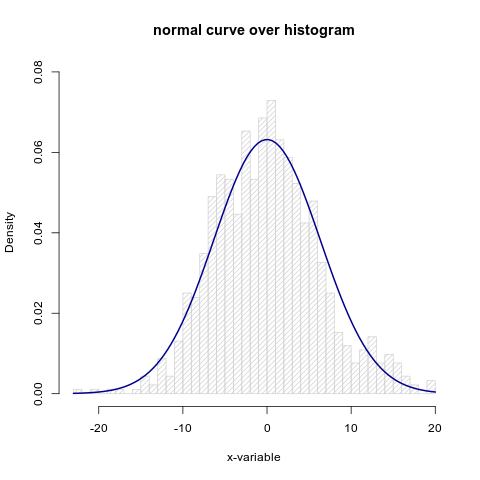

In [21]:
%%R
g2 <- tt_Neutrophils$logFC - mean(tt_Neutrophils$logFC)
m2<-mean(g2)
std2<-sqrt(var(g2))
hist(g2, density=20, breaks=50, prob=TRUE, 
     xlab="x-variable", ylim=c(0, 0.08), 
     main="normal curve over histogram")
curve(dnorm(x, mean=m2, sd=std2), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")

#### 3.1.4 Smear plot (also known as MA, M-values vs A-values, plot):

Shows the log fold-change of the genes as a function of their mean abundance. We generally observe higher logFC at low abundance ranges as read counts are more variable at low abundance resulting in large logFC estimates. If we fit a loess curve to logFC and Average logCPM values, the trend should center around zero. Any deviations from this can indicate that data has not been properly normalised.

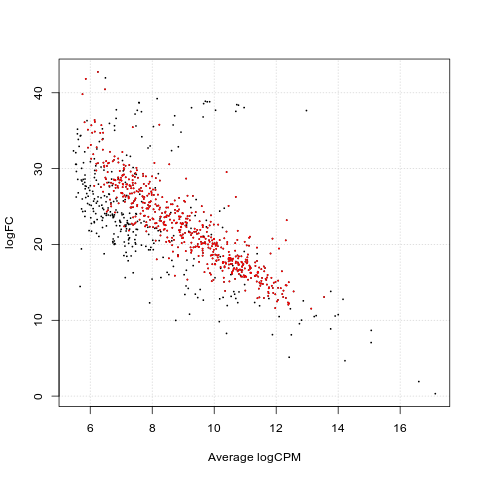

In [22]:
%%R
plotSmear(qlf_Neutrophils, de.tags = rownames(tt_Neutrophils)[which(tt_Neutrophils$FDR<0.01)])

#### 3.1.5 Vulcano plot:

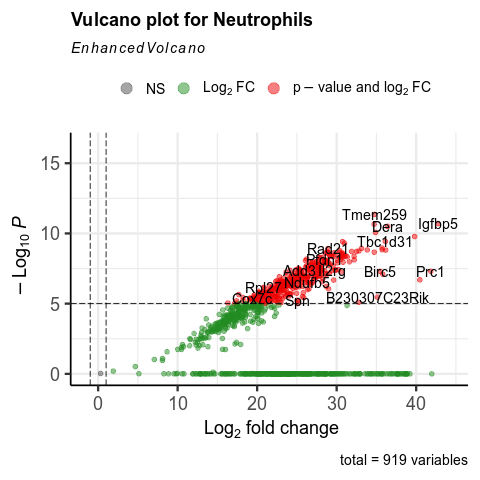

In [25]:
%%R
# default cut-off for log2FC is >|2|; for P value is 10e-6
EnhancedVolcano(tt_Neutrophils,
                lab = rownames(tt_Neutrophils),
                x = 'logFC',
                y = 'PValue',
                title = "Vulcano plot for Neutrophils")

### 3.2 Testing with one cell group - Alveolar macrophages

In [26]:
adata_AlvMacrophages = adata_pb[adata_pb.obs["coarse_harmonized_anno"] == "Alveolar_macrophages"]
adata_AlvMacrophages

View of AnnData object with n_obs × n_vars = 24 × 23767
    obs: 'dataset', 'batch', 'sample', 'condition', 'fibrotic/control', 'coarse_harmonized_anno', 'harmonized_anno', 'author_annotation_coarse', 'author_annotation', 'lib_size', 'log_lib_size'
    uns: 'author_annotation_coarse_colors', 'author_annotation_colors', 'batch_colors', 'coarse_harmonized_anno_colors', 'condition_colors', 'dataset_colors', 'fibrotic', 'harmonized_anno_colors', 'log1p', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [27]:
# clean the sample names to make plots less crowded
adata_AlvMacrophages.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_AlvMacrophages.obs_names
]

In [28]:
%%time
%%R -i adata_AlvMacrophages
outs_AlvMacrophages <- fit_model(adata_AlvMacrophages)

[1] "Dimensions before subsetting:"
[1] 23767    24
[1] ""
[1] "Dimensions after subsetting:"
[1] 8537   24
[1] ""
[1] "conditionasbestos"  "conditionbleomycin" "conditionsaline"   
[4] "conditionuntreated" "projectpeyser"      "projecttsukui"     
[7] "projectxie"        
CPU times: user 5.64 s, sys: 687 ms, total: 6.33 s
Wall time: 5.24 s


In [29]:
%%R
fit_AlvMacrophages <- outs_AlvMacrophages$fit
y_AlvMacrophages <- outs_AlvMacrophages$y

#### 3.2.1 MDS plot:

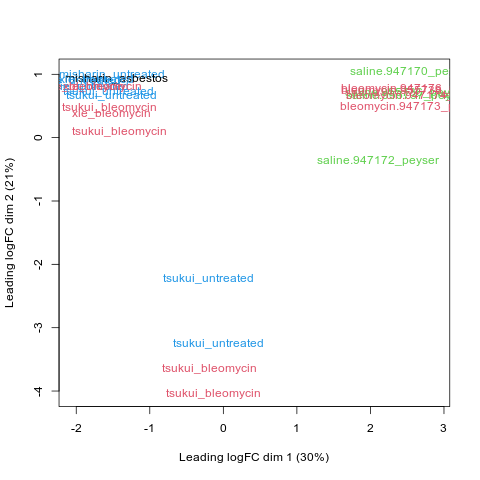

In [30]:
%%R
plotMDS(y_AlvMacrophages, labels = NULL, col = as.numeric(y_AlvMacrophages$samples$group))

#### 3.2.2 BCV plot:

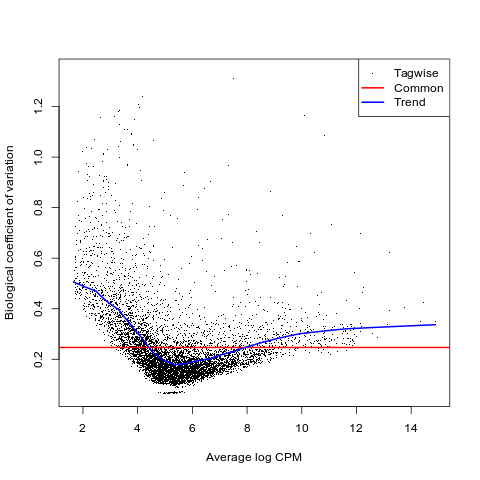

In [31]:
%%R
plotBCV(y_AlvMacrophages)

#### 3.2.3 Quasi-likelihood test to find DE genes between control and stimulated conditions:

In [32]:
%%R
colnames(y_AlvMacrophages$design)

[1] "conditionasbestos"  "conditionbleomycin" "conditionsaline"   
[4] "conditionuntreated" "projectpeyser"      "projecttsukui"     
[7] "projectxie"        


In [33]:
%%R -o tt_AlvMacrophages
myContrast_AlvMacrophages <- makeContrasts('conditionasbestos-conditionbleomycin-conditionsaline-conditionuntreated',
                                           levels = y_AlvMacrophages$design)
qlf_AlvMacrophages <- glmQLFTest(fit_AlvMacrophages, contrast=myContrast_AlvMacrophages)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt_AlvMacrophages <- topTags(qlf_AlvMacrophages, n = Inf)
tt_AlvMacrophages <- tt_AlvMacrophages$table

In [34]:
tt_AlvMacrophages.shape

(8537, 5)

In [35]:
tt_AlvMacrophages.sort_values('logFC', ascending=False)[:5]   # genes with the highest logFC

,logFC,logCPM,F,PValue,FDR
Ccl24,56.413818,3.321655,9.716974e+01,3.494562e-12,4.450705e-12
Prss34,55.978091,1.980948,-7.855098e-08,1.000000e+00,1.000000e+00
Styx,55.204213,4.034618,2.023305e+02,4.277197e-17,8.624098e-17
Rrad,51.707582,2.204218,6.779355e+01,7.922075e-10,9.053649e-10
Emid1,51.663649,1.845292,5.563977e+01,7.813585e-09,8.631545e-09


In [36]:
tt_AlvMacrophages.sort_values('logFC')[:5]   # genes with the lowest logFC

,logFC,logCPM,F,PValue,FDR
Malat1,9.739025,14.333541,2.105753e+01,0.000045,0.000047
Tmsb4x,10.243940,14.880758,2.327817e+01,0.000021,0.000023
Lyz2,11.651471,13.772982,2.117340e+01,0.000043,0.000046
Fth1,11.980005,14.506622,2.960308e+01,0.000003,0.000003
mt-Atp6,11.986565,11.913165,1.608046e-07,0.999682,1.000000


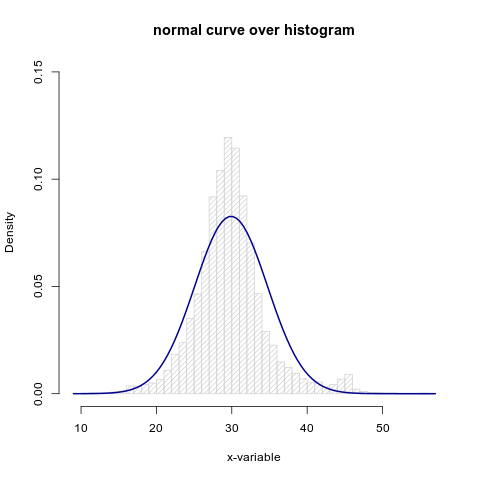

In [37]:
%%R

g3 = tt_AlvMacrophages$logFC
m3<-mean(g3)
std3<-sqrt(var(g3))
hist(g3, density=20, breaks=50, prob=TRUE, 
     xlab="x-variable", ylim=c(0, 0.15), 
     main="normal curve over histogram")
curve(dnorm(x, mean=m3, sd=std3), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")

In [38]:
%%R
print(paste0("Mean: ", round(mean(tt_AlvMacrophages$logFC), 2)))
print(paste0("SD: ", round(sqrt(var(tt_AlvMacrophages$logFC)), 2)))

[1] "Mean: 29.91"
[1] "SD: 4.83"


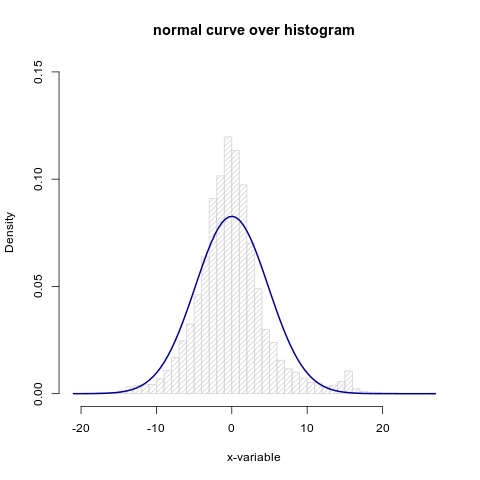

In [39]:
%%R
g4 <- tt_AlvMacrophages$logFC - mean(tt_AlvMacrophages$logFC)
m4<-mean(g4)
std4<-sqrt(var(g4))
hist(g4, density=20, breaks=50, prob=TRUE, 
     xlab="x-variable", ylim=c(0, 0.15), 
     main="normal curve over histogram")
curve(dnorm(x, mean=m4, sd=std4), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")

#### 3.2.4 Smear plot (also known as MA, M-values vs A-values, plot):

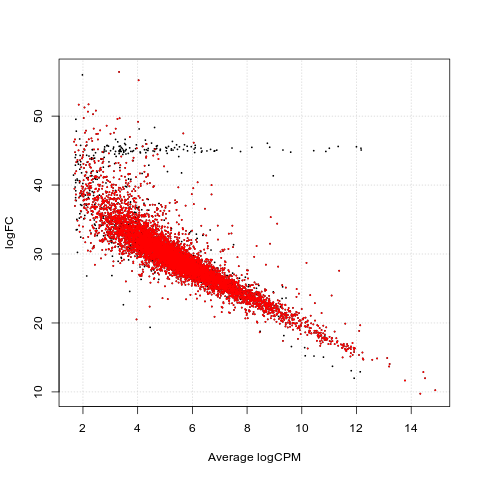

In [40]:
%%R
plotSmear(qlf_AlvMacrophages, de.tags = rownames(tt_AlvMacrophages)[which(tt_AlvMacrophages$FDR<0.01)])

#### 3.2.5 Vulcano plot:

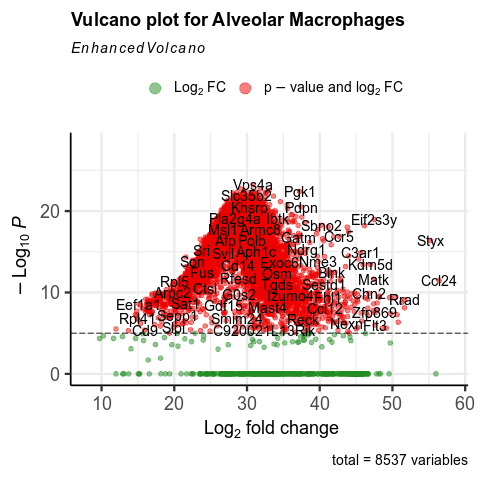

In [41]:
%%R
# default cut-off for log2FC is >|2|; for P value is 10e-6
EnhancedVolcano(tt_AlvMacrophages,
                lab = rownames(tt_AlvMacrophages),
                x = 'logFC',
                y = 'PValue',
                title = "Vulcano plot for Alveolar Macrophages")